# San Francisco Crime Classification
*Predict the category of crimes that occurred in the city by the bay*

[Kaggle Project Link](https://www.kaggle.com/c/sf-crime)

From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.

We're also encouraging you to explore the dataset visually. What can we learn about the city through visualizations like this Top Crimes Map? The top most up-voted scripts from this competition will receive official Kaggle swag as prizes. 

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from IPython.display import display
#import tools as t
from pygeocoder import Geocoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn import svm
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline

# Load Data

In [3]:
train = pd.read_csv('train.csv.zip', parse_dates=['Dates'])
test = pd.read_csv('test.csv.zip', parse_dates=['Dates'])
#print(train[:10])
#print(train['Resolution'])
train.head(10)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564
8,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601
9,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802


##### Other potential derived features:
- Time of Day: 1-6 (group into 4 hour intervals)
- Month of Crime: 1-12
- Convert longtitude and latitude to zipcode/ address


# Data Exploration and Transformation
## Observations:
- Descript tends to have keywords that are repeated in category. Should refine to fewer categories by splitting into words, and choose top key words => figured that we don't have Descript and Resolution in test.
- Address can be cleaned, maybe to street level
- PdDistrict has few unique values, which is good 
- DayOfWeek looks accurate

In [257]:
train.describe(include='all')

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
count,878049,878049,878049,878049,878049,878049,878049,"878,049","878,049"
unique,389257,39,879,7,10,17,23228,nan,nan
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,nan,nan
freq,185,174900,60022,133734,157182,526790,26533,nan,nan
first,2003-01-06 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
last,2015-05-13 23:53:00,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122,38
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-123,38
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122,38


In [259]:
train['Category'].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [261]:
# Count of crimes by PDdistrict
train['PdDistrict'].value_counts()

SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: PdDistrict, dtype: int64

### Create "TimeOfDay", "DayOfMonth","Year" Variable
- We only want to group TimeOfDay into 3-hour blocks to be more generalized. Hence, it has 8 uniques values, from 0-7
- DayOfMonth is also grouped into 2-day blocks, so range from 1-15


In [5]:
train['TimeOfDay'] = (train['Dates'].dt.hour/3).astype(int)
test['TimeOfDay'] = (test['Dates'].dt.hour/3).astype(int)
train['DayOfMonth'] = (train['Dates'].dt.day/2).astype(int)
test['DayOfMonth'] = (test['Dates'].dt.day/2).astype(int)
train['Year'] = (train['Dates'].dt.year).astype(int)
test['Year'] = (test['Dates'].dt.year).astype(int)


In [6]:
train.tail(5)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,TimeOfDay,DayOfMonth,Year
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,0,3,2003
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,0,3,2003
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,0,3,2003
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,0,3,2003
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212,0,3,2003


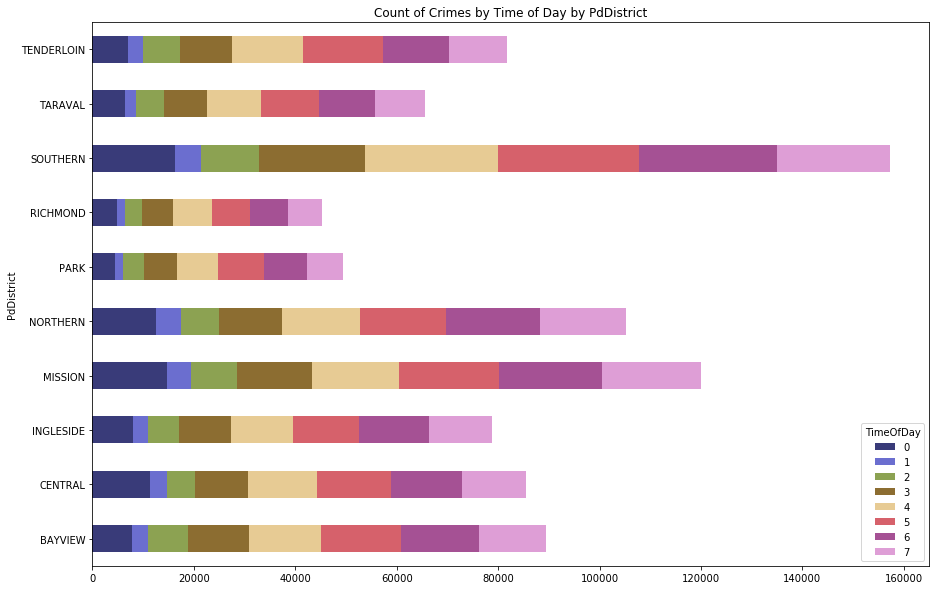

In [34]:
by_district_by_time = train.groupby(['PdDistrict', 'TimeOfDay']).size().unstack()
#plt.figure(figsize=(20, 20))
by_district_by_time.plot(kind='barh', stacked=True, figsize=[15,10], colormap='Vega20b')
plt.title("Count of Crimes by Time of Day by PdDistrict")

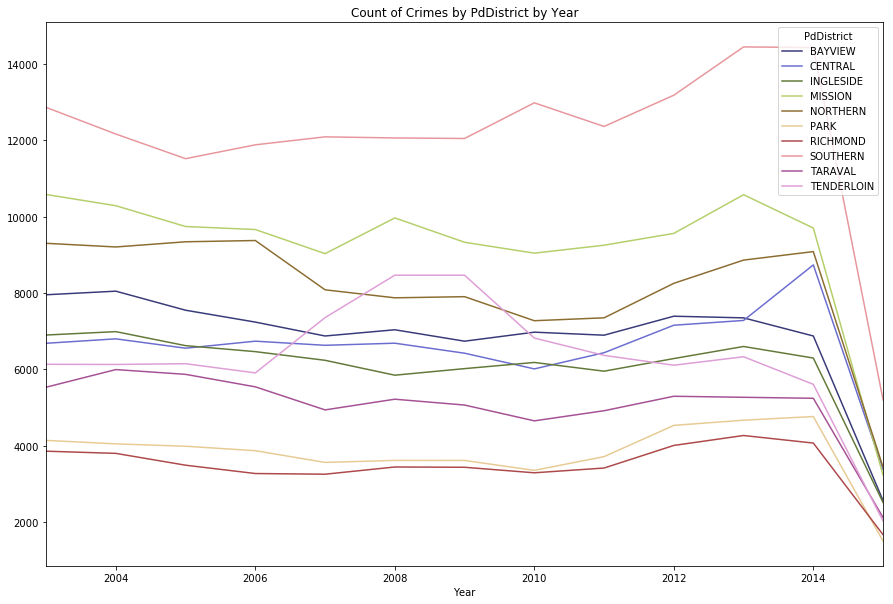

In [41]:
by_district_by_year= train.groupby(['Year', 'PdDistrict']).size().unstack()
#plt.figure(figsize=(20, 20))
by_district_by_year.plot(kind='line',figsize=[15,10], colormap='Vega20b')
plt.title("Count of Crimes by PdDistrict by Year")

The least number of crimes happen from 1-3AM. 

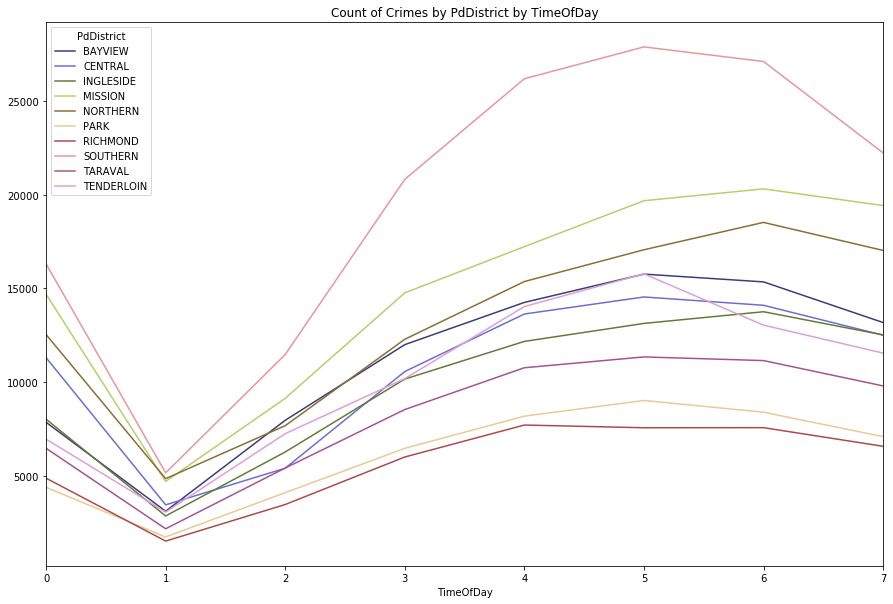

In [42]:
by_district_by_time_2 = train.groupby(['TimeOfDay', 'PdDistrict']).size().unstack()
#plt.figure(figsize=(20, 20))
by_district_by_time_2.plot(kind='line',figsize=[15,10], colormap='Vega20b')
plt.title("Count of Crimes by PdDistrict by TimeOfDay")

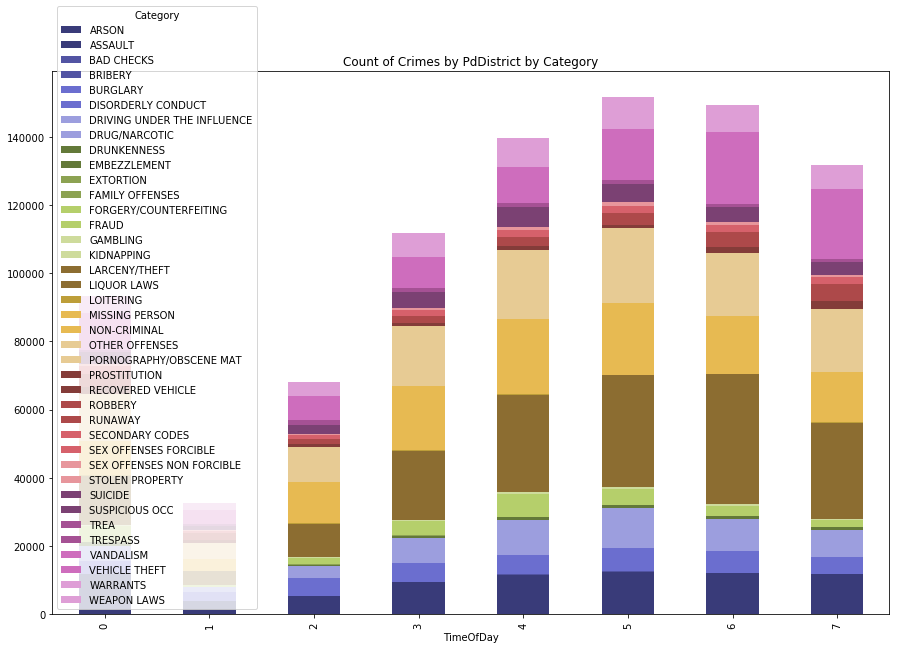

In [56]:
by_time_by_cat = train.groupby(['TimeOfDay','Category',]).size().unstack()
plt.figure(figsize=(10, 10))
by_time_by_cat.plot(kind='bar', stacked = True, figsize=[15,10], colormap='Vega20b', fill = True)
plt.title("Count of Crimes by PdDistrict by Category")

In [51]:
print(train.shape)
print(test.shape)

(878049, 12)
(884262, 10)


In [58]:
train['Address'].apply(lambda x: x.split(' ', 1)[1] if x.split(' ', 1)[0].isdigit() else x)

0                    OAK ST / LAGUNA ST
1                    OAK ST / LAGUNA ST
2             VANNESS AV / GREENWICH ST
3                   Block of LOMBARD ST
4                 Block of BRODERICK ST
5                     Block of TEDDY AV
6                   AVALON AV / PERU AV
7              KIRKWOOD AV / DONAHUE ST
8                      Block of 47TH AV
9         JEFFERSON ST / LEAVENWORTH ST
10        JEFFERSON ST / LEAVENWORTH ST
11                  Block of ESCOLTA WY
12                   TURK ST / JONES ST
13               FILLMORE ST / GEARY BL
14                 Block of WILLIAMS AV
15                  Block of MENDELL ST
16                   EDDY ST / JONES ST
17               GODEUS ST / MISSION ST
18               MENDELL ST / HUDSON AV
19                    Block of JONES ST
20                   Block of EVELYN WY
21                 Block of VALENCIA ST
22                    Block of JONES ST
23                    Block of JONES ST
24             FILLMORE ST / LOMBARD ST


# Training
### Create 3 datasets:
- train_features, train_labels for training
- dev_features, dev_labels for validating
- mini_train_features, mini_train_labelds for light-weight training

In [62]:
# Use about 85% of train dataset for training, the rest for validating
train_features = np.array(train[['DayOfWeek', 'TimeOfDay', 'DayOfMonth', 'Year', 'PdDistrict']])
train_labels = np.array(train['Category'])
X_train, X_test, y_train, y_test = train_test_split(train_features,
                                                    train_labels,
                                                    test_size=0.30,
                                                    random_state=42)

# Use first 1000 rows for light-weight training
X_mini_train= X_train[:1000]
y_mini_train = y_train[:1000]

In [63]:
# Check datashapes for each of the above datasets
print ('train_features shape is', train_features.shape)
print ('train_labels shape is', train_labels.shape)
print ('X_train shape is', X_train.shape)
print ('X_test shape is', X_test.shape)
print ('y_train shape is', y_train.shape)
print ('y_test shape is', y_test.shape)
print ('X_mini_train shape is', X_mini_train.shape)
print ('y_mini_train shape is', y_mini_train.shape)


train_features shape is (878049, 5)
train_labels shape is (878049,)
X_train shape is (614634, 5)
X_test shape is (263415, 5)
y_train shape is (614634,)
y_test shape is (263415,)
X_mini_train shape is (1000, 5)
y_mini_train shape is (1000,)


In [64]:
X_mini_train

array([[   0,    7,   13, 2005,    7],
       [   2,    7,    3, 2004,    1],
       [   4,    5,    5, 2009,    3],
       ..., 
       [   4,    7,    3, 2005,    8],
       [   6,    0,    3, 2010,    2],
       [   1,    4,    0, 2013,    2]])

### Training K-Means

In [ ]:
# data preprocessing for categorical features
cat_features = ['DayOfWeek', 'PdDistrict']
le = preprocessing.LabelEncoder()

# transform categorical features into numeric values using le
for col in cat_features:
    X_train[col] = le.fit_transform(X_train[col]).astype('str')
    X_test[col] = le.fit_transform(X_test[col]).astype('str')

In [144]:
random.seed(100)
knn = KNeighborsClassifier(39)
# fit model using training set
knn.fit(X_mini_train, y_mini_train)
accuracy = knn.score(X_test, y_test)
pred = np.array(knn.predict_proba(X_test))
print ("Accuracy is ", accuracy)
print("Log loss is",log_loss(y_test, pred))

Accuracy is  0.185900575138


ValueError: y_true and y_pred contain different number of classes 39, 31. Please provide the true labels explicitly through the labels argument. Classes found in y_true: ['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS' 'EMBEZZLEMENT'
 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING' 'FRAUD' 'GAMBLING'
 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING' 'MISSING PERSON'
 'NON-CRIMINAL' 'OTHER OFFENSES' 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION'
 'RECOVERED VEHICLE' 'ROBBERY' 'RUNAWAY' 'SECONDARY CODES'
 'SEX OFFENSES FORCIBLE' 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY'
 'SUICIDE' 'SUSPICIOUS OCC' 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT'
 'WARRANTS' 'WEAPON LAWS']

### Random Forests

In [147]:
random.seed(100)
rfc = RandomForestClassifier()
rfc.fit(X_mini_train, y_mini_train)
rfc.score(X_test, y_test)
pred = np.array(rfc.predict_proba(X_test))
print ("Accuracy is ", accuracy)
print("Log loss is",log_loss(y_test, pred))

Accuracy is  0.185900575138


ValueError: y_true and y_pred contain different number of classes 39, 31. Please provide the true labels explicitly through the labels argument. Classes found in y_true: ['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS' 'EMBEZZLEMENT'
 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING' 'FRAUD' 'GAMBLING'
 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING' 'MISSING PERSON'
 'NON-CRIMINAL' 'OTHER OFFENSES' 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION'
 'RECOVERED VEHICLE' 'ROBBERY' 'RUNAWAY' 'SECONDARY CODES'
 'SEX OFFENSES FORCIBLE' 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY'
 'SUICIDE' 'SUSPICIOUS OCC' 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT'
 'WARRANTS' 'WEAPON LAWS']

### Decision Tree

In [145]:
random.seed(100)
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
clf.fit(X_mini_train, y_mini_train)
clf.score(X_test, y_test)
pred = clf.predict_proba(X_test)
print ("Accuracy is ", accuracy)
print("Log loss is", log_loss(y_test, pred))

Accuracy is  0.185900575138


ValueError: y_true and y_pred contain different number of classes 39, 31. Please provide the true labels explicitly through the labels argument. Classes found in y_true: ['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS' 'EMBEZZLEMENT'
 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING' 'FRAUD' 'GAMBLING'
 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING' 'MISSING PERSON'
 'NON-CRIMINAL' 'OTHER OFFENSES' 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION'
 'RECOVERED VEHICLE' 'ROBBERY' 'RUNAWAY' 'SECONDARY CODES'
 'SEX OFFENSES FORCIBLE' 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY'
 'SUICIDE' 'SUSPICIOUS OCC' 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT'
 'WARRANTS' 'WEAPON LAWS']

### Logistic Regression